# 1. Visual Search - Images exploration

# Visual Search with Azure Cognitive Search, Sentence Transformers, Azure Computer Vision and bar code/QR code detection

## 1. Description
The goal of this is **Azure AI asset is to enable search over Text and Images using Azure Cognitive Search**. The technique was inspired by a research article which show how to **convert vectors (embeddings) to text which allows the Cognitive Search service to leverage the inverted index to quickly find the most relevant items**. For this reason, any model that will convert an object to a vector can be leveraged if the number of dimensions in the resulting vector is less than 3,000. It also allows users to leverage existing pretrained or fine-tuned models.<br><br>

This technique has shown to be incredibly effective and easy to implement. We are using **Sentence Transformers, which is an OpenAI clip model wrapper**. We need to embed all our existing catalog of images. Then the objects embedding are converted into a set of fake terms and all the results are stored into an Azure Cognitive Search index for handling all the search requests.
For example, if an embedding looked like [-0,21, .123, ..., .876], this might be converted to a set of fake terms such as: “A1 B3 … FED0”. This is what is sent as the search query to Azure Cognitive Search.<br><br>

We can **enrich the Azure Cognitive Search index by using extracted text from the images using Azure Read API**. We can also detect and extract any information from **bar code and/or QR code** that might be available in the products catalog images. And we can use also **Azure Computer Vision as well to detect the dominant colors of the image, the tags that can describe the image and the caption of each image**. All these information will be ingested into the Azure Cognitive Search index.<br><br>

The goal of this asset is to be able to use the inverted index within Azure Cognitive Search to be able to quickly find vectors stored in the search index that are like a vector provided as part of a search query and/or using any AI extracted information (text, dominant colors, …). Unlike techniques like cosine similarity which are slow to process large numbers of items, this leverages an inverted index which enables much more data to be indexed and searched.<br>

## 2. Process

- We have here a collection of catalog images (466 images).
- For each of these images, we will embed them using Sentence Transformers.  Sentence Transformer can be used to map images and texts to the same vector space. As model, we use the OpenAI CLIP Model which was trained on a large set of images and image alt texts.
- We can retrieve any text from these images using Azure Read API (if any text is available)
- We can retrieve any text information from any bar code or QR code (if any)
- All these information will be ingested into an Azure Cognitive Search index
- Then if you have a field image, you can embed it and extract any text/barcode information and call the Azure Cognitive Search index to retrieve any similar images using vecText similarity and/or using any query text from the extracted text


<img src="https://github.com/retkowsky/images/blob/master/process.png?raw=true">

Field images are available in the field images directory (number of images=53)


## 3. Azure products documentation
- https://azure.microsoft.com/en-us/products/search/ 
- https://azure.microsoft.com/en-us/products/cognitive-services/computer-vision/#overview 
- https://learn.microsoft.com/en-us/azure/cognitive-services/Computer-vision/how-to/call-read-api 
- https://zbar.sourceforge.net/ 
- https://github.com/liamca/vector-search

## 4. Research article
https://www.researchgate.net/publication/305910626_Large_Scale_Indexing_and_Searching_Deep_Convolutional_Neural_Network_Features
    
## 5. Directories
- **images**: We have two directories (catalog images, field images)
- **model**: Directory to save the clusters of the model
- **results**: Directory to save some results
- **test**: Directory that contains some testing images

## 6. Python notebooks

### 0. Settings.ipynb
Notebook that contains the link to the images and the importation process of the python required libraries

### 1. Catalog images exploration.ipynb
This notebook will display some catalog and field images

### 2.OpenAI Clip and VecText Clusters.ipynb
This notebook will explain what sentence transformers is and will generate the clusters
This notebook analyzes a set of existing images to determine a set of "cluster centers" that will be used to determine which "fake words" are generated for a vector
This notebook will take a test set of files (testSamplesToTest) and determine the optimal way to cluster vectors into fake words that will be indexed into Azure Cognitive Search

### 3. VecText generation.ipynb
This notebook will generate the vectext embedding for all the catalog images

### 4. BarCode Information extraction.ipynb
This notebook will detect any barcode or QR code from the catalog images and will extract the information

### 5. Azure CV for OCR, tags, colors and captions.ipynb
This notebook will use Azure Computer Vision or OCR, colors, tags and caption extraction for each of the catalog images.

### 6. Azure Cognitive Search Index Generation.ipynb
This notebook will show how to ingest all the information into an Azure Cognitive Search index.

### 7. Calling Azure Cognitive Search.ipynb
We can now test the index using some images similarity visual search or free text queries using azure Cognitive Search.

## 7. Python files

- **azureCognitiveSearch.py**
This python file contains many functions to manage and use Azure Cognitive Search

- **myfunctions.py**
This python file contains many generic functions used in all the notebooks

- **vec2Text.py**
This python file contains some functions for the sentence transformers model


18-oct-2022 Serge Retkowsky | serge.retkowsky@microsoft.com | https://www.linkedin.com/in/serger/

In [1]:
import concurrent.futures
import configparser
import cv2
import datetime
import json
import kaleido
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'notebook'
import random
import seaborn as sns
import sys
import warnings

warnings.filterwarnings("ignore")

import myfunctions as my

from azureml.core import Workspace, Dataset, Datastore
import azureml.core
from azureml.data.datapath import DataPath

%matplotlib inline

In [2]:
my.get_system_info()

System Informations:

{
  "Architecture": "x86_64",
  "Hostname": "standardd13",
  "IP-address": "127.0.0.1",
  "MAC-address": "60:45:bd:90:9b:99",
  "Platform": "Linux",
  "Platform-release": "5.4.0-1077-azure",
  "Platform-version": "#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022",
  "Processor": "x86_64",
  "Python version": "3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]",
  "RAM": "55 Gb"
}


In [3]:
my.check_python()

You are using Python: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
This notebook was made using Python 3.8.5 so this is OK


In [4]:
print(my.get_today())

18-10-2022 13:46:17


Storage:

Total: 126.8 GB
- Used: 62.1 GB | 49.02 %
- Free: 64.6 GB | 50.96 %


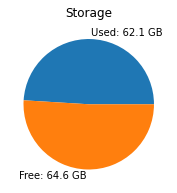

(126774263808, 62147858432, 64609628160)

In [5]:
my.get_storage_infos()

In [6]:
config_file = 'azureconfig.ini'

config = configparser.ConfigParser()
config.read(config_file)

subscription_id = config.get('AzureML', 'subscription_id')
resource_group = config.get('AzureML', 'resource_group')
workspace_name = config.get('AzureML', 'workspace_name')
                            
ws = Workspace(subscription_id, resource_group, workspace_name)

In [7]:
print("Azure ML version:", azureml.core.VERSION)

Azure ML version: 1.41.0


In [8]:
from azureml.core.experiment import Experiment
experiment = Experiment(workspace=ws, name="VisualSearch")

In [9]:
experiment

Experiment(Name: VisualSearch,
Workspace: azuremlvision)

## 1. Images

In [10]:
CATALOG_IMAGES = 'images/catalog_images'
FIELD_IMAGES = 'images/field_images'

In [11]:
my.number_files(CATALOG_IMAGES)

images/catalog_images = 466

The directory images/catalog_images contains 466 files


In [12]:
my.number_files(FIELD_IMAGES)

images/field_images = 53

The directory images/field_images contains 53 files


In [13]:
EDA_FOLDER = 'eda_images'
my.create_dir(EDA_FOLDER)

Done. Directory: eda_images has been created


## 2. Catalog products images

Image file: images/catalog_images/catalog_image_00002.jpg 
Width = 640 Height = 853 
Size: 78.1 kB Date: 2022-09-29 09:26:32


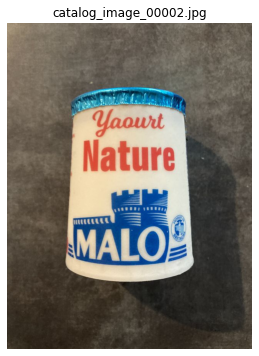

In [14]:
my.image_view_index(CATALOG_IMAGES, 1)

Image file: images/catalog_images/catalog_image_00101.jpg 
Width = 640 Height = 853 
Size: 101.0 kB Date: 2022-09-29 09:26:36


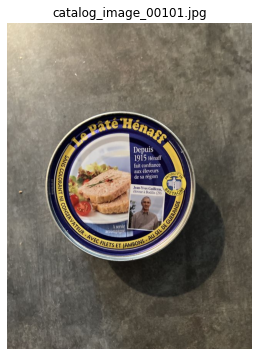

In [15]:
my.image_view_index(CATALOG_IMAGES, 100)

### Some random images

Some 9 random images from the 466 images:


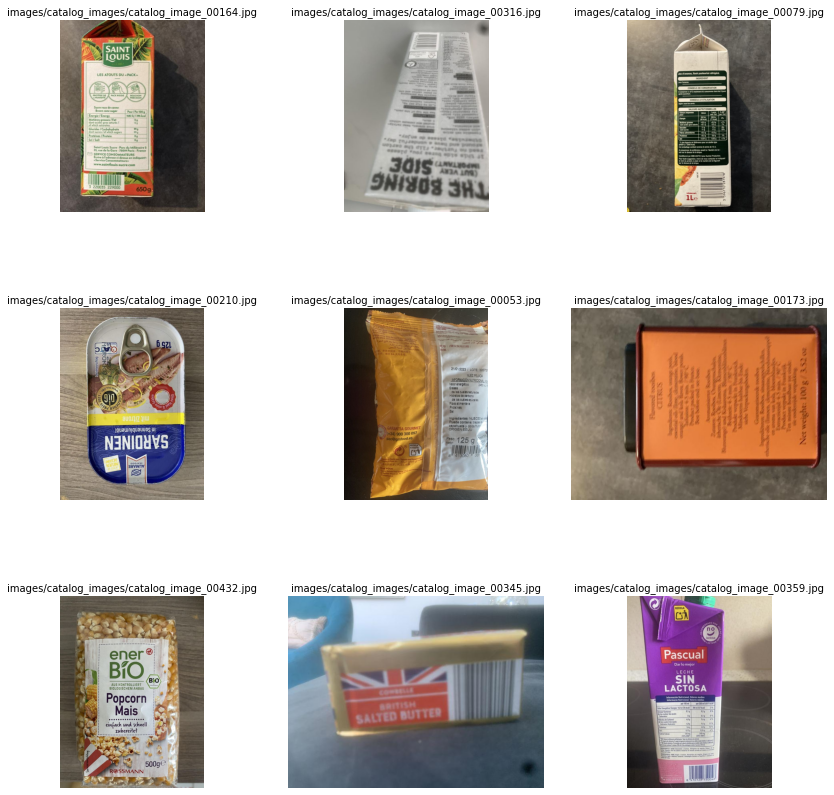

In [16]:
my.display_random_images(CATALOG_IMAGES,
                         nb_images=9,
                         nb_cols=3,
                         hspace=0.5,
                         wspace=0.05,
                         titlesize=10)

## 3. Field images

Image file: images/field_images/field_image_00002.jpg 
Width = 640 Height = 853 
Size: 94.0 kB Date: 2022-09-29 09:24:50


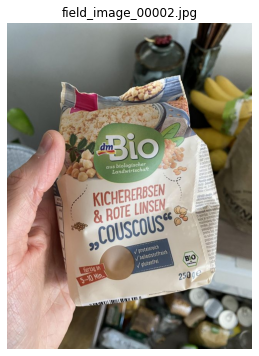

In [17]:
my.image_view_index(FIELD_IMAGES, 1)

Some 6 random images from the 53 images:


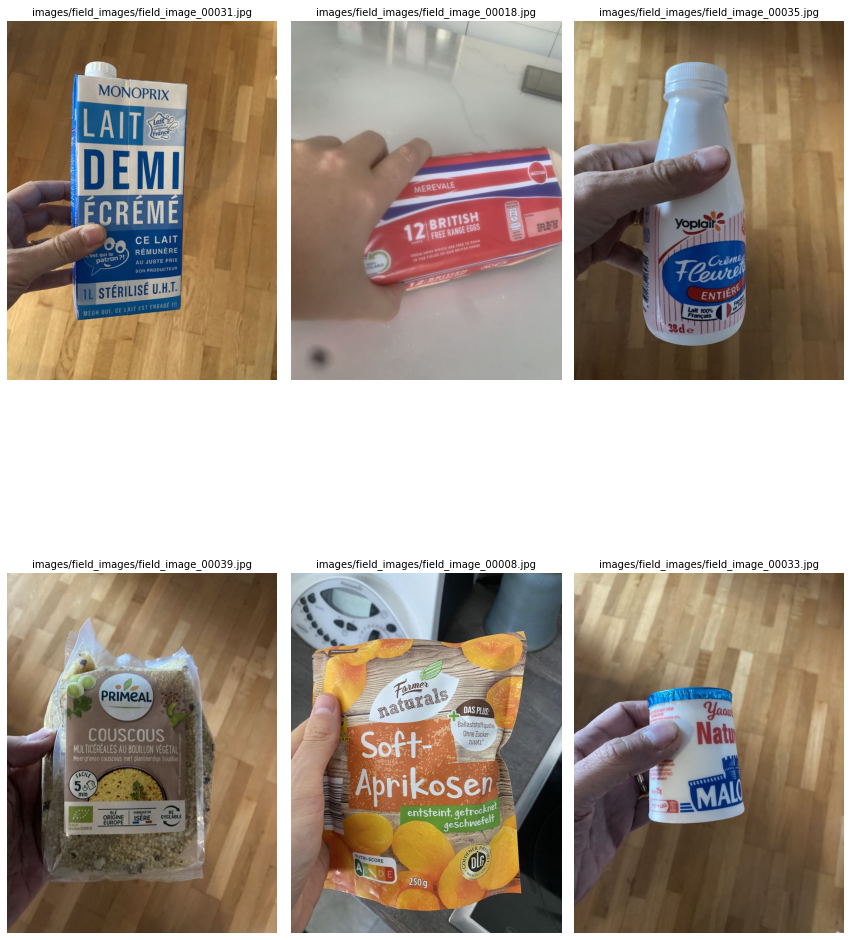

In [18]:
my.display_random_images(FIELD_IMAGES,
                         nb_images=6,
                         nb_cols=3,
                         hspace=0.05,
                         wspace=0.05,
                         titlesize=10)

## 4. Images EDA

In [19]:
images_list = [
    file for file in os.listdir(CATALOG_IMAGES)
    if file.endswith(('jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG'))
]
len(images_list)

466

In [20]:
def images_EDA(imagefile, display=False):
    """
    Simple function for images EDA
    """
    filename = CATALOG_IMAGES + '/' + imagefile
    img = cv2.imread(filename)
    img2 = cv2.imread(filename, 0)
    dimensions = img.shape
    img_h = dimensions[0]
    img_w = dimensions[1]
    img_resolution = img_w * img_h
    img_ratio = round(img_w / img_h, 5)
    img_size = os.path.getsize(filename)
    img_date = datetime.datetime.fromtimestamp(
        pathlib.Path(filename).stat().st_mtime)
    img_ext = os.path.splitext(imagefile)[1]

    if display:
        print("Image file:", filename)
        print("Image height:", img_h)
        print("Image width:", img_w)
        print("Image resolution:", img_resolution)
        print("Image ratio:", img_ratio)
        print("File size:", img_size)
        print("File date:", img_date)
        print("File extension:", img_ext)

    return imagefile, img_h, img_w, img_resolution, img_ratio, img_size, img_date, img_ext

### Testing on a single image

In [21]:
images_EDA(images_list[0], display=True)

Image file: images/catalog_images/catalog_image_00001.jpg
Image height: 853
Image width: 640
Image resolution: 545920
Image ratio: 0.75029
File size: 108364
File date: 2022-09-29 09:26:28
File extension: .jpg


('catalog_image_00001.jpg',
 853,
 640,
 545920,
 0.75029,
 108364,
 datetime.datetime(2022, 9, 29, 9, 26, 28),
 '.jpg')

### Running images EDA

In [22]:
maxworkers = 40

In [23]:
eda_dict = {
    "image_file_name": [],
    "height": [],
    "width": [],
    "resolution": [],
    "image_ratio": [],
    "file_size": [],
    "file_date": [],
    "file_extension": []
}
idx = 0
idx2 = 0
start = my.now()

print("Running images EDA...\n")

# Launching a parralel task for the EDA
with concurrent.futures.ThreadPoolExecutor(max_workers=maxworkers) as executor:
    results = executor.map(images_EDA, images_list)

    for imagefile, img_h, img_w, img_resolution,\
    img_ratio, img_size, img_date, img_ext in results:

        if idx % 100 == 1:
            idx2 = idx - 1
            nb_todo = len(images_list) - idx2
            pct_done = round((idx2 / len(images_list)) * 100)
            print(my.get_today(), "Number of processed files:", f"{idx2:9}",
                  "| Remaining files:", f"{nb_todo:9}", "| Done:", pct_done,
                  "%")

        eda_dict["image_file_name"].append(imagefile)
        eda_dict["height"].append(img_h)
        eda_dict["width"].append(img_w)
        eda_dict["resolution"].append(img_resolution)
        eda_dict["image_ratio"].append(img_ratio)
        eda_dict["file_size"].append(img_size)
        eda_dict["file_date"].append(img_date)
        eda_dict["file_extension"].append(img_ext)

        idx += 1

eda_df = pd.DataFrame.from_dict(eda_dict)
eda_dict.clear()

print("\nEnd of job. Number of processed files =", idx)
print("\nDone in", (my.now() - start).in_words(locale='en'))
print("Average time per image =",
      ((my.now() - start) / len(images_list)).in_words(locale='en'))

Running images EDA...

18-10-2022 13:47:15 Number of processed files:         0 | Remaining files:       466 | Done: 0 %
18-10-2022 13:47:17 Number of processed files:       100 | Remaining files:       366 | Done: 21 %
18-10-2022 13:47:18 Number of processed files:       200 | Remaining files:       266 | Done: 43 %
18-10-2022 13:47:20 Number of processed files:       300 | Remaining files:       166 | Done: 64 %
18-10-2022 13:47:22 Number of processed files:       400 | Remaining files:        66 | Done: 86 %

End of job. Number of processed files = 466

Done in 7 seconds
Average time per image = 0.02 second


### EDA Results

In [24]:
eda_df

image_file_name  height  width  resolution  image_ratio  \
0    catalog_image_00001.jpg     853    640      545920      0.75029   
1    catalog_image_00002.jpg     853    640      545920      0.75029   
2    catalog_image_00003.jpg     853    640      545920      0.75029   
3    catalog_image_00004.jpg     853    640      545920      0.75029   
4    catalog_image_00005.jpg     480    640      307200      1.33333   
..                       ...     ...    ...         ...          ...   
461  catalog_image_00462.jpg     480    640      307200      1.33333   
462  catalog_image_00463.jpg     853    640      545920      0.75029   
463  catalog_image_00464.jpg     480    640      307200      1.33333   
464  catalog_image_00465.jpg     480    640      307200      1.33333   
465  catalog_image_00466.jpg     480    640      307200      1.33333   

     file_size           file_date file_extension  
0       108364 2022-09-29 09:26:28           .jpg  
1        78069 2022-09-29 09:26:32           .jpg  
2        36293 2022-09-29 09:27:14           .jpg  
3        41034 2022-09-29 09:27:14           .jpg  
4        29315 2022-09-29 09:27:14           .jpg  
..         ...                 ...            ...  
461      22180 2022-09-29 09:27:12           .jpg  
462      37400 2022-09-29 09:27:12           .jpg  
463      25657 2022-09-29 09:27:12           .jpg  
464      25390 2022-09-29 09:27:12           .jpg  
465      24468 2022-09-29 09:27:14           .jpg  

[466 rows x 8 columns]

### Saving to Azure ML datastore

In [28]:
eda_df.to_csv(EDA_FOLDER + '/images_eda_df.csv')

In [31]:
workspace = Workspace(subscription_id, resource_group, workspace_name)
datastore = workspace.get_default_datastore()

ds = Dataset.File.upload_directory(src_dir=EDA_FOLDER,
                                   target=DataPath(datastore,EDA_FOLDER),
                                   show_progress=True,
                                   overwrite=True)

Validating arguments.
Arguments validated.
Uploading file to eda_images
Uploading an estimated of 1 files
Uploading eda_images/images_eda_df.csv
Uploaded eda_images/images_eda_df.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Creating new dataset


In [32]:
# to get the ds
ds = Dataset.Tabular.from_delimited_files(datastore.path('eda_images/images_eda_df.csv'))

In [33]:
# Registering the ds
ds = ds.register(workspace=workspace,
                 name='images_eda',
                 description='images EDA visual search',
                 create_new_version=True)

In [34]:
eda_df.sort_values(by='resolution')

image_file_name  height  width  resolution  image_ratio  \
298  catalog_image_00299.jpg     432    576      248832      1.33333   
281  catalog_image_00282.jpg     576    432      248832      0.75000   
282  catalog_image_00283.jpg     432    576      248832      1.33333   
260  catalog_image_00261.jpg     576    432      248832      0.75000   
277  catalog_image_00278.jpg     432    576      248832      1.33333   
..                       ...     ...    ...         ...          ...   
388  catalog_image_00389.jpg    3468    576     1997568      0.16609   
386  catalog_image_00387.jpg     576   3468     1997568      6.02083   
64   catalog_image_00065.jpg    3854    640     2466560      0.16606   
387  catalog_image_00388.jpg    3854    640     2466560      0.16606   
391  catalog_image_00392.jpg    3854    640     2466560      0.16606   

     file_size           file_date file_extension  
298      22202 2022-09-29 10:04:36           .jpg  
281      17765 2022-09-29 10:04:36           .jpg  
282      17929 2022-09-29 10:04:36           .jpg  
260      14372 2022-09-29 10:04:36           .jpg  
277      13439 2022-09-29 10:04:36           .jpg  
..         ...                 ...            ...  
388     210789 2022-09-29 10:04:36           .jpg  
386     204160 2022-09-29 10:04:38           .jpg  
64      292940 2022-09-29 09:27:38           .jpg  
387     277712 2022-09-29 10:04:40           .jpg  
391     277712 2022-09-29 10:04:32           .jpg  

[466 rows x 8 columns]

In [35]:
print("Height statistics:")
print("Mean =", eda_df['height'].mean(), "Min =", eda_df['height'].min(),
      "Max =", eda_df['height'].max())
print("\nWidth statistics:")
print("Mean =", eda_df['width'].mean(), "Min =", eda_df['width'].min(),
      "Max =", eda_df['width'].max())
print("\nResolution statistics:")
print("Mean =", eda_df['resolution'].mean(), "Min =",
      eda_df['resolution'].min(), "Max =", eda_df['resolution'].max())
print("\nFile size statistics:")
print("Mean =", eda_df['file_size'].mean(), "Min =", eda_df['file_size'].min(),
      "Max =", eda_df['file_size'].max())

Height statistics:
Mean = 782.5557939914163 Min = 432 Max = 3854

Width statistics:
Mean = 663.9055793991416 Min = 432 Max = 3468

Resolution statistics:
Mean = 513150.62660944206 Min = 248832 Max = 2466560

File size statistics:
Mean = 71229.04935622317 Min = 13439 Max = 292940


In [36]:
fig = px.histogram(eda_df,
                   x="file_size",
                   title="Images file size",
                   color_discrete_sequence=["blue"])
fig.show()
fig.write_image(EDA_FOLDER + "/filesize_hist.png")

In [37]:
fig = px.box(eda_df,
             x="file_size",
             title="Images file size",
             color_discrete_sequence=["blue"])
fig.show()
fig.write_image(EDA_FOLDER + "/filesize_boxplot.png")

In [38]:
fig = px.histogram(eda_df,
                   x="resolution",
                   title="Images resolution",
                   color_discrete_sequence=["royalblue"])
fig.show()
fig.write_image(EDA_FOLDER + "/resolution_hist.png")

In [39]:
fig = px.box(eda_df,
             x="resolution",
             title="Images resolution",
             color_discrete_sequence=["royalblue"])
fig.show()
fig.write_image(EDA_FOLDER + "/resolution_boxplot.png")

In [40]:
fig = px.histogram(eda_df,
                   x="image_ratio",
                   title="Images resolution",
                   color_discrete_sequence=["green"])
fig.show()
fig.write_image(EDA_FOLDER + "/ratio_hist.png")

In [41]:
fig = px.box(eda_df,
             x="image_ratio",
             title="Images resolution",
             color_discrete_sequence=["green"])
fig.show()
fig.write_image(EDA_FOLDER + "/ratio_boxplot.png")

In [42]:
fig = px.histogram(
    eda_df,
    x="width",
    title="Images width",
    color_discrete_sequence=[px.colors.qualitative.Alphabet[10]])
fig.show()
fig.write_image(EDA_FOLDER + "/width_hist.png")

In [43]:
fig = px.box(eda_df,
             x="width",
             title="Images width",
             color_discrete_sequence=[px.colors.qualitative.Alphabet[10]])
fig.show()
fig.write_image(EDA_FOLDER + "/width_boxplot.png")

In [44]:
fig = px.histogram(eda_df,
                   x="height",
                   title="Images height",
                   color_discrete_sequence=["purple"])
fig.show()
fig.write_image(EDA_FOLDER + "/height_hist.png")

In [45]:
fig = px.box(eda_df,
             x="height",
             title="Images height",
             color_discrete_sequence=["purple"])
fig.show()
fig.write_image(EDA_FOLDER + "/height_boxplot.png")

In [46]:
fig = px.scatter(eda_df,
                 x="width",
                 y="height",
                 marginal_y="violin",
                 marginal_x="box",
                 title="Images height vs width")
fig.show()
fig.write_image(EDA_FOLDER + "/width_height_plot.png")

In [47]:
fig = px.parallel_coordinates(eda_df, title="Images height vs width")
fig.show()
fig.write_image(EDA_FOLDER + "/height_width_resolution_filesize_plot.png")

In [48]:
fig = go.Figure(data=[
    go.Pie(labels=eda_df.file_extension.unique(),
           values=eda_df['file_extension'].value_counts())
])

fig.update_layout(title='Images files extension')
fig.show()
fig.write_image(EDA_FOLDER + "/extensions_pie.png")

> End of notebook